In [6]:
# dados processados do Global dataset of thermohaline staircases obtained from Argo floats and Ice-Tethered Profilers
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import glob

In [7]:
#nc_files = sorted(glob.glob("C:/Users\locfa_v05v5qi/Documents/escadas_termohalinas/raw/Dataset/**/*.nc", recursive=True))
nc_files = sorted(glob.glob("C:/Users/aneli/Documents/LOC/PC_casa/Dataset/**/*.nc", recursive=True))

In [8]:
#RECORTE REGIONAL

def subset_region(ds):

    # Ajustar longitudes se estiverem em 0–360
    if float(ds.lon.max()) > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -60) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds

In [9]:
points = {
    "lon": [],
    "lat": [],
    "depth": [],
    "type": [],
    "thickness": []
}

In [10]:
total_profiles = 0
profiles_with_staircase = 0
profiles_without_staircase = 0

for fname in nc_files:
    try:
        ds = xr.open_dataset(fname)
        ds = subset_region(ds)

        # Número de perfis restantes após o recorte
        nobs = ds.sizes.get("Nobs", 0)

        total_profiles += nobs
        
        if nobs == 0:
            ds.close()
            continue

        for i in range(nobs):

            has_sf = np.any(ds.mask_ml_sf_layer[i, :] > 0)
            has_dc = np.any(ds.mask_ml_dc_layer[i, :] > 0)
        
            lat = float(ds.lat[i])
            lon = float(ds.lon[i])
        
            #if lon > 180:
             #   lon -= 360
        
            # CLASSIFICAÇÃO DO PERFIL
        
            if has_sf or has_dc:
                profiles_with_staircase += 1
            else:
                profiles_without_staircase += 1
        
                # Armazena perfil sem staircase
                points["lon"].append(lon)
                points["lat"].append(lat)
                points["depth"].append(np.nan)
                points["type"].append("None")
                points["thickness"].append(np.nan)
        
                continue 
        
            # SALT-FINGER
            sf = ds.mask_ml_sf_layer[i, :]
        
            for j in np.where(sf > 0)[0]:
                points["lon"].append(lon)
                points["lat"].append(lat)
                points["depth"].append(float(ds.ml_p[i, j]))
                points["type"].append("Salt-finger")
                points["thickness"].append(float(ds.ml_h[i, j]))
                
            # DIFFUSIVE
            dc = ds.mask_ml_dc_layer[i, :]
        
            for j in np.where(dc > 0)[0]:
                points["lon"].append(lon)
                points["lat"].append(lat)
                points["depth"].append(float(ds.ml_p[i, j]))
                points["type"].append("Diffusive")
                points["thickness"].append(float(ds.ml_h[i, j]))

        ds.close()

    except Exception as e:
        print("Erro em", fname, "->", e)
        
percent_with = 100 * profiles_with_staircase / total_profiles
percent_without = 100 * profiles_without_staircase / total_profiles

print("\nResumo:")
print("Total de perfis:", total_profiles)
print("Perfis com staircase:", profiles_with_staircase)
print(f"Porcentagem com staircase: {percent_with:.2f}%")
print("Perfis sem staircase:", profiles_without_staircase)
print(f"Porcentagem sem staircase: {percent_without:.2f}%")



Resumo:
Total de perfis: 23633
Perfis com staircase: 19529
Porcentagem com staircase: 82.63%
Perfis sem staircase: 4104
Porcentagem sem staircase: 17.37%


In [11]:
print("Total de pontos com staircases (ML):", len(points["lon"]))

Total de pontos com staircases (ML): 119796


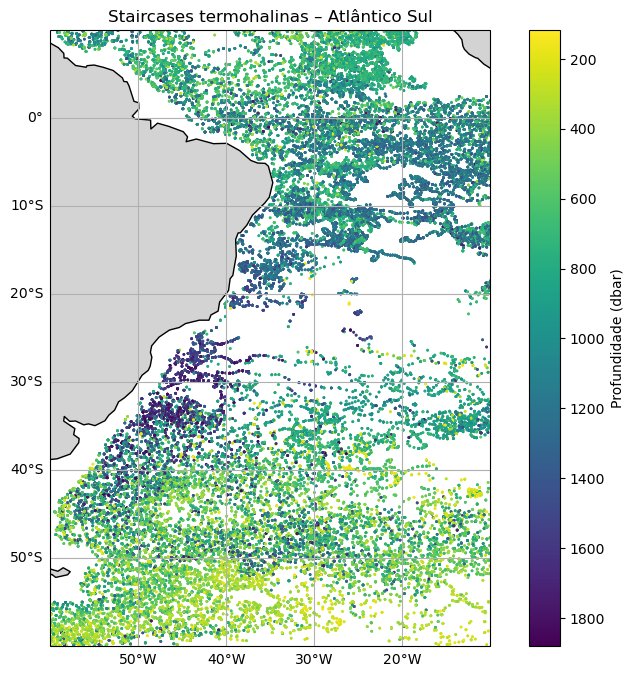

In [12]:
# converter listas em numpy arrays
for k in points:
    points[k] = np.array(points[k])

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-60, -10, -60, 10], crs=ccrs.PlateCarree())

# mapa base
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# plotar pontos
sc = ax.scatter(
    points["lon"],
    points["lat"],
    c=points["depth"],         
    s=1,                     
    cmap="viridis_r",
    transform=ccrs.PlateCarree()
)

# barra de cores
cb = plt.colorbar(sc, ax=ax, label="Profundidade (dbar)")
cb.ax.invert_yaxis()

plt.title("Staircases termohalinas – Atlântico Sul")
plt.show()

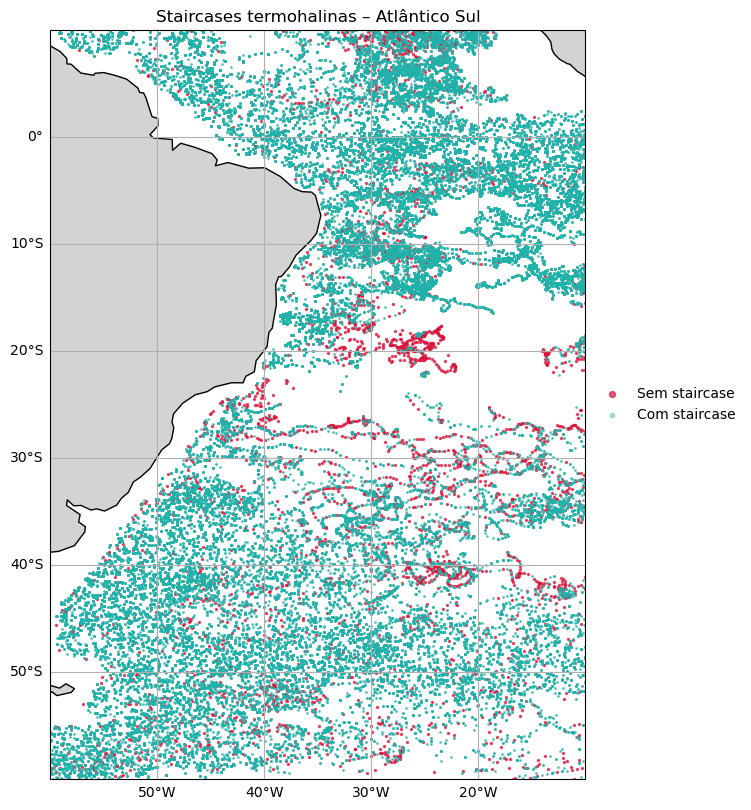

In [14]:
# Separar máscaras por tipo
mask_none = points["type"] == "None"
mask_stair = points["type"] != "None"

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-60, -10, -60, 10], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Perfis SEM staircase (cinza)
ax.scatter(
    points["lon"][mask_none],
    points["lat"][mask_none],
    color="crimson",
    alpha=0.7,
    s=2,
    transform=ccrs.PlateCarree(),
    label="Sem staircase"
)

# Perfis COM staircase (colorido por profundidade)
sc = ax.scatter(
    points["lon"][mask_stair],
    points["lat"][mask_stair],
    color="lightseagreen",
    alpha=0.4,
    s=1,
    transform=ccrs.PlateCarree(),
    label="Com staircase"
)

ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    markerscale=3
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.title("Staircases termohalinas – Atlântico Sul")
plt.show()
